In [1]:
import causalnex
import pandas as pd
import numpy as np
from numpy import asarray

#for splitting, scaling and encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#for pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

#for drawing causal graph
from causalnex.structure.notears import from_pandas

import warnings
from pandas import DataFrame
warnings.filterwarnings("ignore")

/home/selam/anaconda3/envs/cas/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("../data/data2.csv")
data.drop("Unnamed: 0", axis=1, inplace = True)

In [3]:
data

,texture_mean,area_mean,smoothness_mean,concavity_mean,fractal_dimension_mean,area_se,smoothness_se,concavity_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,10.38,1001.0,0.11840,0.30010,0.07871,153.40,0.006399,0.05373,0.006193,0.16220,0.7119,0.4601,0.11890,M
1,17.77,1326.0,0.08474,0.08690,0.05667,74.08,0.005225,0.01860,0.003532,0.12380,0.2416,0.2750,0.08902,M
2,21.25,1203.0,0.10960,0.19740,0.05999,94.03,0.006150,0.03832,0.004571,0.14440,0.4504,0.3613,0.08758,M
3,20.38,386.1,0.14250,0.24140,0.09744,27.23,0.009110,0.05661,0.009208,0.20980,0.6869,0.6638,0.17300,M
4,14.34,1297.0,0.10030,0.19800,0.05883,94.44,0.011490,0.05688,0.005115,0.13740,0.4000,0.2364,0.07678,M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,22.39,1479.0,0.11100,0.24390,0.05623,158.70,0.010300,0.05198,0.004239,0.14100,0.4107,0.2060,0.07115,M
565,28.25,1261.0,0.09780,0.14400,0.05533,99.04,0.005769,0.03950,0.002498,0.11660,0.3215,0.2572,0.06637,M
566,28.08,858.1,0.08455,0.09251,0.05648,48.55,0.005903,0.04730,0.003892,0.11390,0.3403,0.2218,0.07820,M
567,29.33,1265.0,0.11780,0.35140,0.07016,86.22,0.006522,0.07117,0.006185,0.16500,0.9387,0.4087,0.12400,M


### split data set to training and holdout set and return the training dataset

In [4]:

def labeler(df, col):
    """
    A function that change categorical to numerical
    """
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    return(df)

In [5]:
def splitter(df, rand=20, test=.2):
    """
    A function to split the dataset to test and holdout set
    """
    train_df, valid_df = train_test_split(df, random_state=rand, test_size=test)
    return (train_df)

In [6]:
def scaler(df):
    """
    A function that scale a dataset
    """
    scaler = MinMaxScaler()
    # transform data
    scaled = scaler.fit_transform(df)
    print(df.shape)
    return (scaled)
    

In [7]:
def rename_col(sc):
    """
    A function that rename scaled columns
    to their original name
    """
    df = DataFrame(sc)
    dic={}
    for i in range(len(df.columns.to_list())):
        dic[i]=data.columns.to_list()[i]
    df.rename(columns = dic, inplace=True)
    return df

In [8]:
# a pipeline to process data and gives us the trained datasetset
pipe = Pipeline(steps=[("labeler", FunctionTransformer(labeler, kw_args={'col':'diagnosis'})),
    ("split", FunctionTransformer(splitter, kw_args={'rand':20, 'test':0.2})),
                        ("scaler", FunctionTransformer(scaler)),
                        ("rename_col", FunctionTransformer(rename_col))])

In [9]:
train_df = pipe.fit_transform(data)
train_df

(455, 14)


,texture_mean,area_mean,smoothness_mean,concavity_mean,fractal_dimension_mean,area_se,smoothness_se,concavity_se,fractal_dimension_se,smoothness_worst,concavity_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,0.391003,0.053150,0.293907,0.087512,0.401860,0.000000,0.129245,0.094318,0.127420,0.247177,0.149201,0.192682,0.242818,0.0
1,0.549827,1.000000,0.605735,0.851687,0.145814,1.000000,0.201822,0.203409,0.126556,0.426137,0.545767,0.255643,0.126131,1.0
2,0.205882,0.183245,0.435973,0.041050,0.269535,0.019514,0.071897,0.017874,0.027714,0.364723,0.096326,0.294844,0.149416,0.0
3,0.340138,0.227953,0.469643,0.159888,0.174884,0.028088,0.125846,0.054369,0.031687,0.333025,0.135783,0.191019,0.071822,0.0
4,0.469550,0.271135,0.340828,0.232849,0.079535,0.055618,0.273855,0.127551,0.072800,0.276894,0.185463,0.295557,0.051358,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,0.386851,0.460870,0.447486,0.298032,0.136047,0.219646,0.173063,0.087020,0.108833,0.423496,0.288898,0.357567,0.180441,1.0
451,0.341522,0.262057,0.541653,0.268744,0.303953,0.047419,0.103784,0.060202,0.077256,0.554910,0.317572,0.576859,0.336875,1.0
452,0.092042,0.103712,0.496470,0.076500,0.296279,0.011894,0.161777,0.032374,0.066408,0.426798,0.101837,0.277501,0.165158,0.0
453,0.181315,0.091368,0.522103,0.119845,0.428140,0.005220,0.093857,0.069621,0.130495,0.409628,0.268770,0.241388,0.347370,0.0


## causal graph with training dataset

In [10]:
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
from IPython.display import Image

def causal_graph(df):
    """
    A function to draw causal graph
    """
    viz = plot_structure(
        sm,
        graph_attributes={"scale": "1.4", "size": 2.2},
        all_node_attributes=NODE_STYLE.WEAK,
        all_edge_attributes=EDGE_STYLE.WEAK,)
    
    return(Image(viz.draw(format='png')))


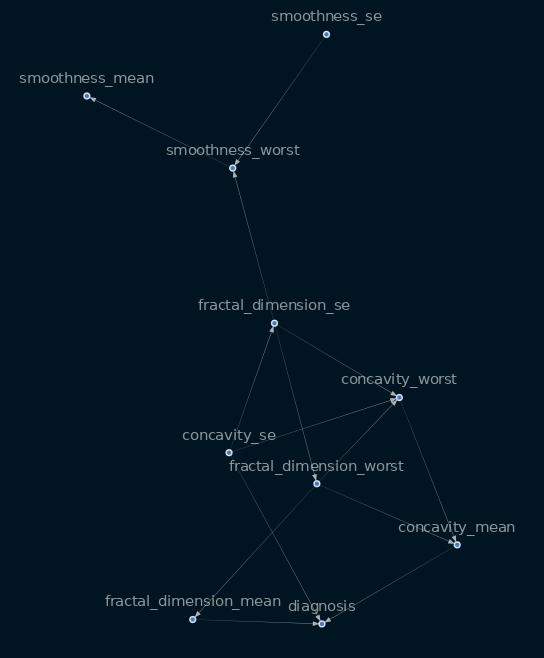

In [11]:
sm = from_pandas(train_df)
sm.remove_edges_below_threshold(0.8)
sm = sm.get_largest_subgraph()

causal_graph(train_df)

### create causal graph by increasing fraction of the data

* 80% of the data

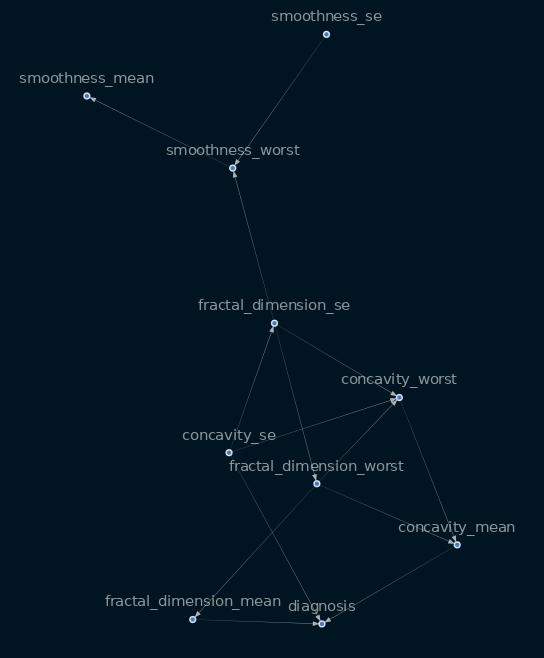

In [12]:
df1 = train_df[:int(len(train_df)*0.8)]

sm1 = from_pandas(df1)
sm1.remove_edges_below_threshold(0.8)
sm1 = sm1.get_largest_subgraph()
causal_graph(df1)

* 70% of the data

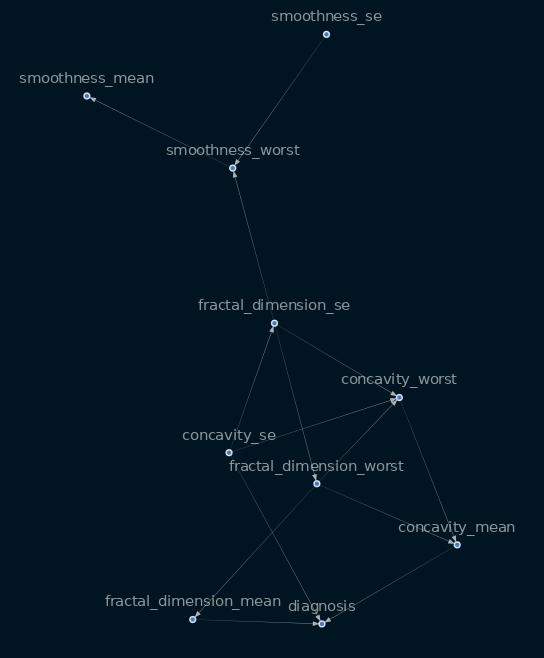

In [13]:
df2 = train_df[:int(len(train_df)*0.7)]

sm2 = from_pandas(df2)
sm2.remove_edges_below_threshold(0.8)
sm2 = sm2.get_largest_subgraph()
causal_graph(df2)

* 60% of the data

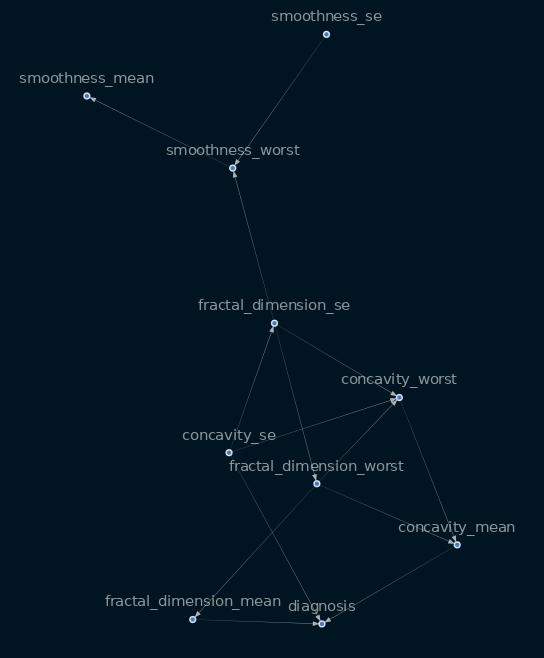

In [14]:
df3 = train_df[:int(len(train_df)*0.6)]

sm3 = from_pandas(df3)
sm3.remove_edges_below_threshold(0.8)
sm3 = sm3.get_largest_subgraph()
causal_graph(df3)

### compare the ground of truth causal graph with the graph of increasing fractions of data

In [16]:
def jaccard_set(list1, list2):
    """Define Jaccard Similarity function for two sets"""
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union


In [17]:
#100% vs 80%
jaccard_set(sm.edges, sm1.edges)

0.7058823529411765

In [18]:
#100% vs 70%
jaccard_set(sm.edges, sm2.edges)

0.7222222222222222

In [19]:
#100% vs 60%
jaccard_set(sm.edges, sm3.edges)

0.5909090909090909